## Step 1: Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import os
import warnings
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import plot_model
from keras.callbacks import Callback, ReduceLROnPlateau
from keras.optimizers import Adam
from PIL import Image, ImageFile

warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True

2025-06-03 13:29:11.382076: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-03 13:29:11.424095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-03 13:29:12.138256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Step Bonus: Define Reusable Functions

To streamline the process, reusable functions for generating paths and plotting metrics are defined:

In [2]:
def image_path(image_name):
    """Returns the full path of an image given its name."""
    return os.path.join(images_dir, image_name)

def model_path(model_name):
    """Returns the full path of a model given its name."""
    return os.path.join(model_dir, model_name)
    
def plot_metric(history):
    """Plots training and validation accuracy/loss curves."""
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_accuracy) + 1)
    
    plt.plot(epochs, train_accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, train_loss,label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.legend(["train_loss", 'val_loss'])

    plt.show()

## Step 2: Data Preprocessing

### 2.1 Set Up Directories

In [3]:
train_dir = 'DATASET/TRAIN'
test_dir = 'DATASET/TEST'

images_dir = './outputs/Images'
model_dir = './outputs/Models'

os.makedirs(images_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [4]:
class_names = sorted(os.listdir(train_dir))
no_classes = len(class_names)

print(f"Classes :{class_names}")
print(f"Total Number of Classes : {no_classes}")

Classes :['downdog', 'goddess', 'plank', 'tree', 'warrior2']
Total Number of Classes : 5


In [5]:
class_dis_tr = [len(os.listdir(train_dir + f"/{name}")) for name in class_names]
print(class_dis_tr)

class_dis_te = [len(os.listdir(test_dir + f"/{name}")) for name in class_names]
print(class_dis_te)

[223, 180, 266, 160, 252]
[98, 80, 116, 69, 109]


### 2.2 Initialize Data

In [6]:
batch_size=16

EPOCHS = 50

### 2.3 Data augmentation

In [7]:
train_datagen = IDG(shear_range=0.2,      
                    zoom_range=0.2,       
                    horizontal_flip=True, 
                    rescale = 1./255      
                    )

test_datagen = IDG(rescale = 1./255 )     

In [8]:
train_generator =  train_datagen.flow_from_directory(train_dir,                 
                                                    target_size = (224,224),    
                                                    color_mode = 'rgb',         
                                                    class_mode = 'categorical', 
                                                    batch_size = batch_size     
                                                     )

validation_generator  = test_datagen.flow_from_directory(test_dir,              
                                                  target_size = (224,224),
                                                  color_mode = 'rgb',
                                                  class_mode = 'categorical'
                                                 )

Found 1081 images belonging to 5 classes.
Found 474 images belonging to 5 classes.


In [9]:
print("number of images", train_generator.samples)
print("number of class", len(train_generator.class_indices))
print("number of images in the classes", train_generator.samples / len(train_generator.class_indices))

print("number of images", validation_generator.samples)
print("number of class", len(validation_generator.class_indices))
print("number of images in the classes", validation_generator.samples / len(validation_generator.class_indices))

number of images 1081
number of class 5
number of images in the classes 216.2
number of images 474
number of class 5
number of images in the classes 94.8


In [10]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import os

def plot_images(path):
    count = 1
    fig = plt.figure(figsize=(10, 10))
    for i in os.listdir(path):
        f_path = os.path.join(path, i)
        fig.add_subplot(5, 5, count)
        plt.imshow(load_img(f'{os.path.join(f_path, os.listdir(f_path)[0])}'))
        plt.axis('off')
        plt.title(f'{i}')
        count += 1
    plt.show()


In [11]:
import pandas as pd
import os


data = []
for label in os.listdir(train_dir):
    label_folder = os.path.join(train_dir, label)
    if os.path.isdir(label_folder): 
        for filename in os.listdir(label_folder):
            data.append({'filename': filename, 'label': label})

train_df = pd.DataFrame(data)


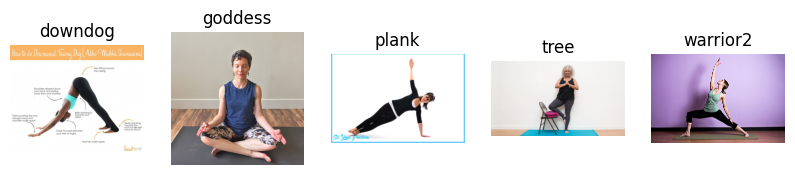

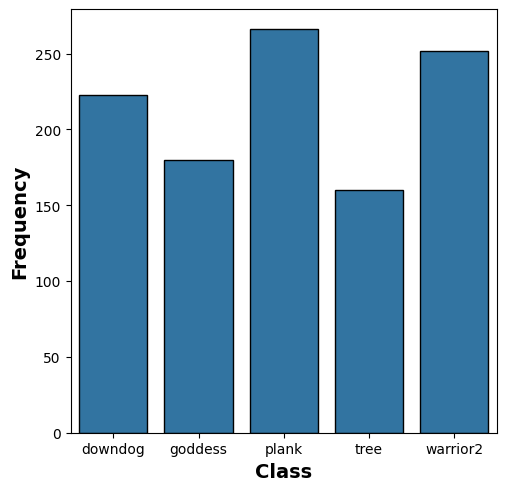

In [12]:
plot_images(train_dir)


import seaborn as sns
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='label', data=train_df, edgecolor='black')
plt.xlabel('Class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.savefig('plot_class_distribution.pdf')


## Step 3: Model Creation

### 3.1 Model Creation

In [13]:
model_name = "Yoga-Pose-Classification"

In [15]:
vgg16 = VGG16(include_top=False,
              weights='imagenet',
              input_shape=(224,224,3),
              pooling=None)

In [16]:
for layer in vgg16.layers:
    layer.trainable = False

In [17]:
def create_baseline():

    model_vgg = Sequential(name=model_name+"_VGG")
    model_vgg.add(vgg16)

    model_vgg.add(Flatten(name='flattened'))                                    
    model_vgg.add(Dropout(0.5, name='dropout1'))                                
    model_vgg.add(Dense(256, activation='relu'))                                
    model_vgg.add(Dropout(0.2, name='dropout2'))                                
    model_vgg.add(Dense(no_classes, activation='softmax', name='predictions'))  

    return model_vgg

In [18]:
model_vgg = create_baseline()

In [19]:
model_vgg.summary()

Model: "Yoga-Pose-Classification_VGG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flattened (Flatten)         (None, 25088)             0         
                                                                 
 dropout1 (Dropout)          (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout2 (Dropout)          (None, 256)               0         
                                                                 
 predictions (Dense)         (None, 5)                 1285      
                                                                 
Total params: 21138757 (80.64 MB)
Trai

In [20]:
model_vgg.build()

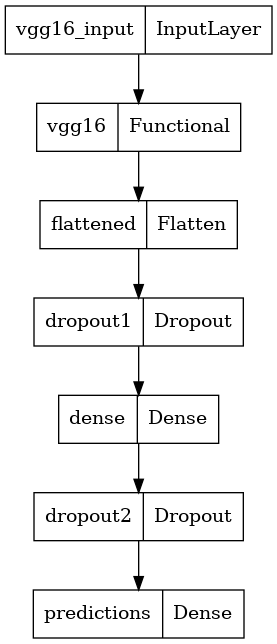

In [21]:
plot_model(model_vgg)

## Step 4: Compile Model

In [22]:
model_vgg.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),          
    metrics=["accuracy"]            
)

## Step 5: Define Callbacks

In [23]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',    
                                            patience=3,     
                                            verbose=1,      
                                            factor=0.5,     
                                            min_lr=0.00001  
                                 )

In [24]:
cbs = [lr_reduction]

## Step 6: Train the Model

In [25]:
history = model_vgg.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    batch_size=batch_size,
                    callbacks=cbs,
                    shuffle=True)

Epoch 1/50


2025-06-03 13:33:54.915971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-06-03 13:33:55.451300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-06-03 13:33:55.536438: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55863023a080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-03 13:33:55.536464: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-06-03 13:33:55.540925: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-03 13:33:55.653016: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

68/68 [==============================] - 23s 315ms/step - loss: 1.4947 - accuracy: 0.5948 - val_loss: 0.2151 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 2/50
68/68 [==============================] - 21s 307ms/step - loss: 0.4960 - accuracy: 0.8252 - val_loss: 0.1706 - val_accuracy: 0.9599 - lr: 0.0010
Epoch 3/50
68/68 [==============================] - 21s 307ms/step - loss: 0.4044 - accuracy: 0.8585 - val_loss: 0.1281 - val_accuracy: 0.9599 - lr: 0.0010
Epoch 4/50
68/68 [==============================] - 20s 301ms/step - loss: 0.2592 - accuracy: 0.9223 - val_loss: 0.1500 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 5/50
68/68 [==============================] - 21s 314ms/step - loss: 0.2680 - accuracy: 0.9130 - val_loss: 0.1122 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 6/50
68/68 [==============================] - 20s 301ms/step - loss: 0.2197 - accuracy: 0.9269 - val_loss: 0.1146 - val_accuracy: 0.9641 - lr: 0.0010
Epoch 7/50
68/68 [==============================] - 21s 300ms/step - loss: 

## Step 7: Evaluate: Plot the Graphs

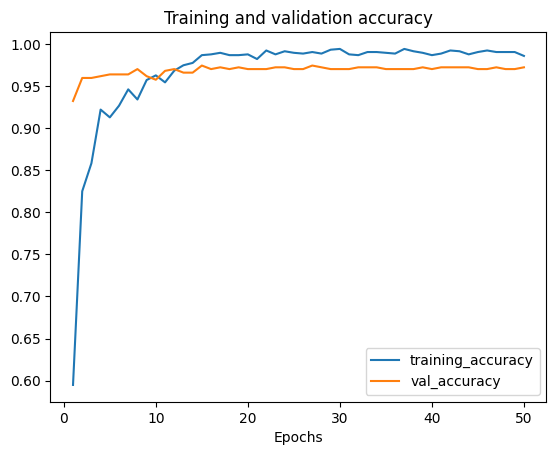

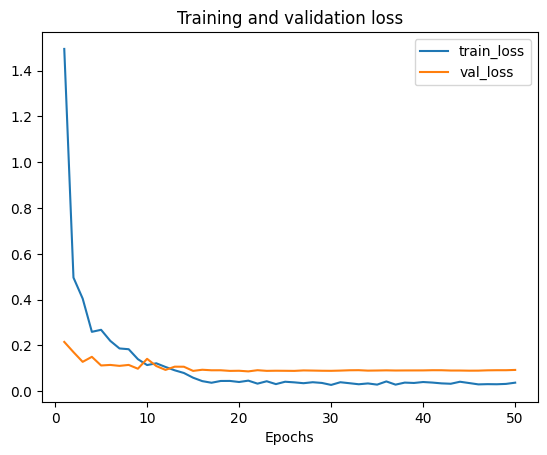

In [26]:
plot_metric(history)

In [27]:
train_loss, train_acc = model_vgg.evaluate(train_generator)
test_loss, test_acc   = model_vgg.evaluate(validation_generator)

print(f"Final Train Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {test_acc * 100:.2f}%")

15/15 [==============================] - 6s 409ms/step - loss: 0.0928 - accuracy: 0.9726
Final Train Accuracy: 99.72%
Final Validation Accuracy: 97.26%


In [28]:
val_generator_noshuffle = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,   
    batch_size=batch_size
)




Found 474 images belonging to 5 classes.


In [29]:
y_true = val_generator_noshuffle.classes
y_pred = model_vgg.predict(val_generator_noshuffle, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)


30/30 [==============================] - 7s 212ms/step


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


              precision    recall  f1-score   support

     downdog       0.99      0.98      0.98        98
     goddess       0.95      0.95      0.95        80
       plank       0.97      0.98      0.98       118
        tree       0.96      1.00      0.98        69
    warrior2       0.98      0.95      0.97       109

    accuracy                           0.97       474
   macro avg       0.97      0.97      0.97       474
weighted avg       0.97      0.97      0.97       474



Found 474 images belonging to 5 classes.
30/30 [==============================] - 6s 203ms/step


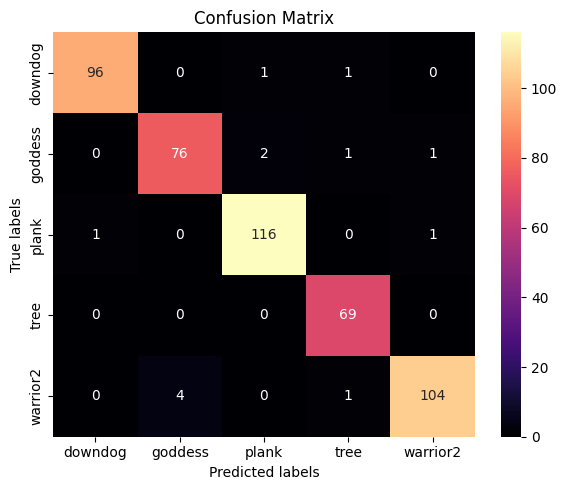

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_generator_noshuffle = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    batch_size=batch_size
)

y_true = val_generator_noshuffle.classes
y_pred = model_vgg.predict(val_generator_noshuffle, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


PartitionExplainer explainer: 6it [00:10, 10.29s/it]               


✅ SHAP Explanation for class: downdog


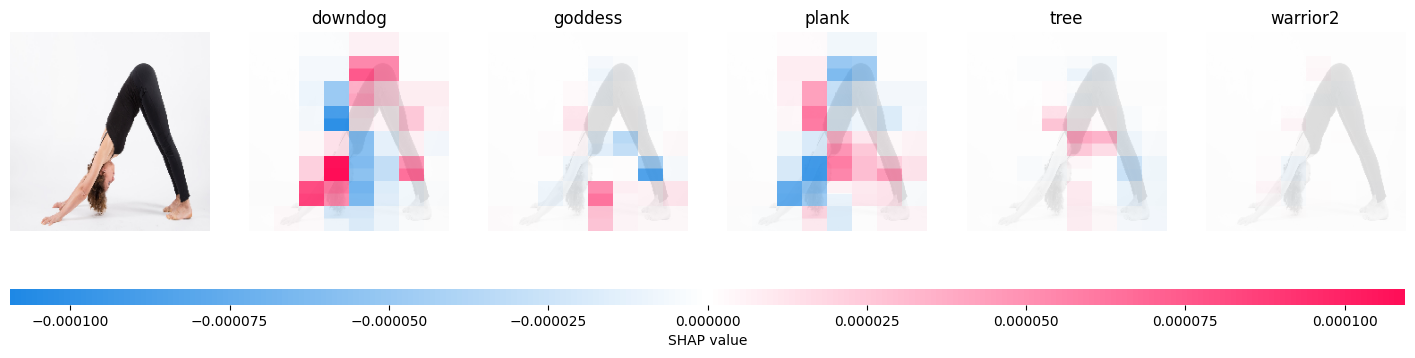

✅ SHAP Explanation for class: goddess


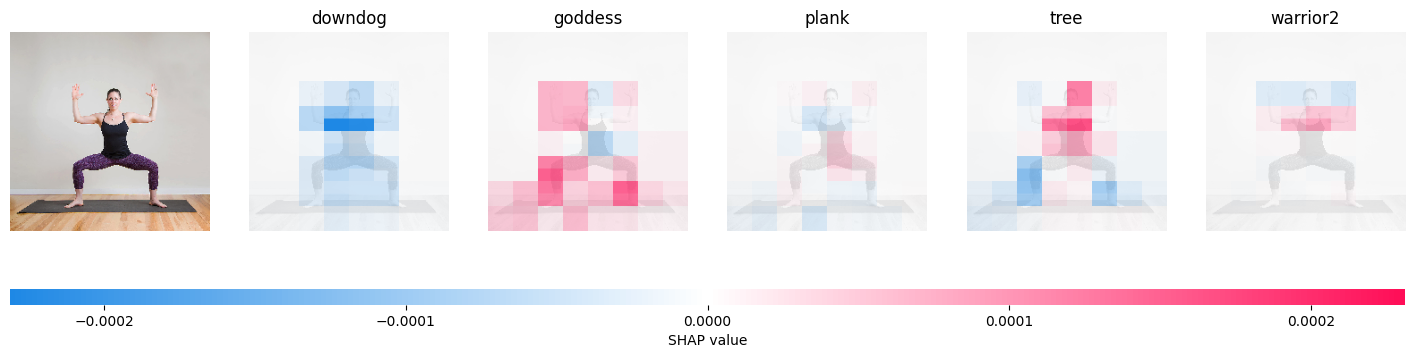

✅ SHAP Explanation for class: plank


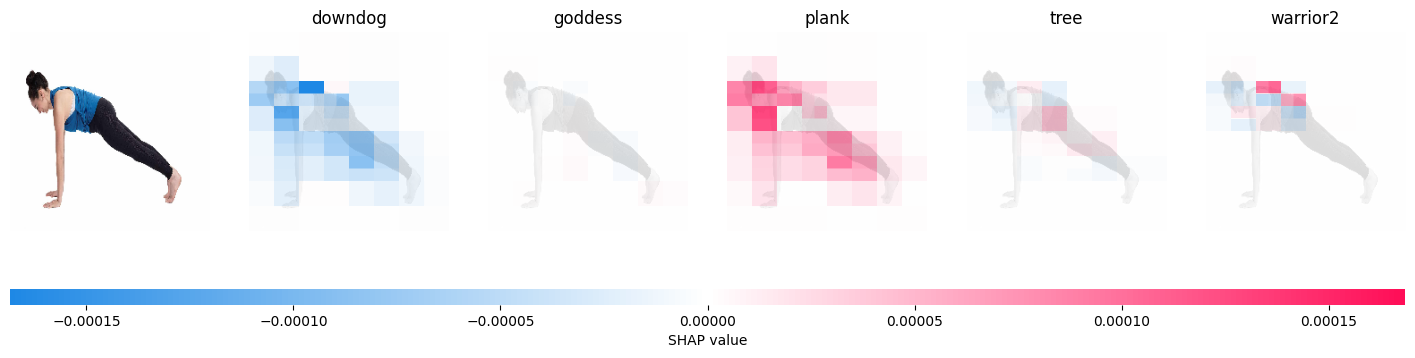

✅ SHAP Explanation for class: tree


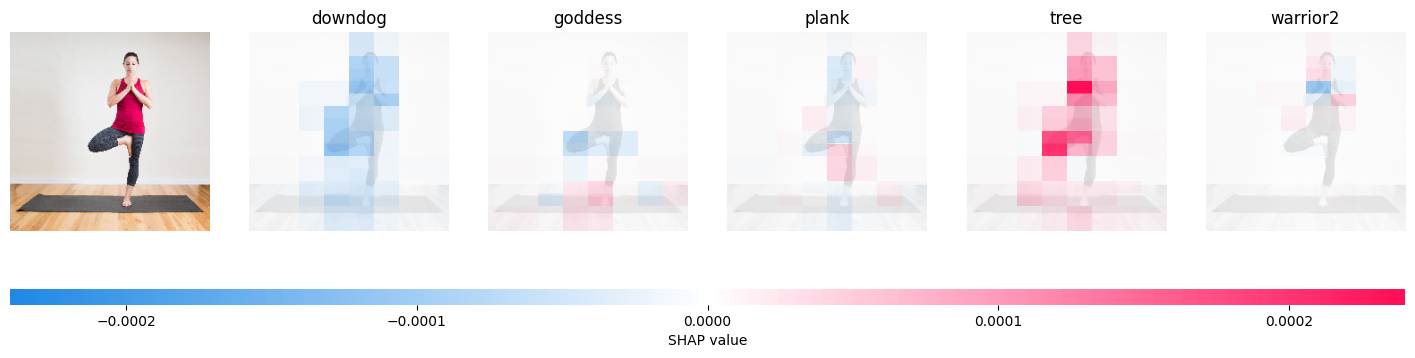

✅ SHAP Explanation for class: warrior2


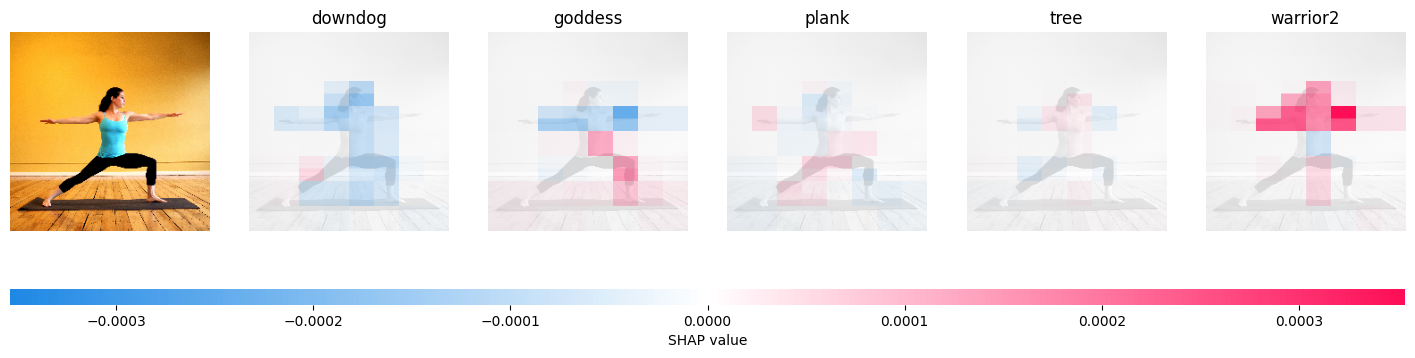

In [32]:
import shap
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()

x_all = []
y_all = []
for i in range(len(val_generator_noshuffle)):
    x_batch, y_batch = val_generator_noshuffle[i]
    x_all.append(x_batch)
    y_all.append(y_batch)
x_all = np.concatenate(x_all)
y_all = np.concatenate(y_all)

x_selected = []
label_names = []
label_indices = np.argmax(y_all, axis=1)

for i, cls in enumerate(class_names):
    indices = np.where(label_indices == i)[0]
    if len(indices) > 0:
        idx = indices[0]
        x_selected.append(x_all[idx])
        label_names.append(cls)
    else:
        print(f"⚠️ Class '{cls}' not found in the dataset, skipping.")

x_selected = np.stack(x_selected)

masker = shap.maskers.Image("blur(64, 64)", x_selected[0].shape)
explainer = shap.Explainer(model_vgg, masker, output_names=class_names)
shap_values = explainer(x_selected)

for i in range(len(x_selected)):
    print(f"✅ SHAP Explanation for class: {label_names[i]}")
    shap.plots.image(shap_values[i])




